# Imports

In [31]:
import pydotplus
from IPython.display import Image
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz

from classification_utilities import *

In [2]:
DATA_PATH = get_path()

In [6]:
df_indicators = pd.read_csv(DATA_PATH + 'indicators_clean.csv', sep='#')
#df_tweets_ind = pd.read_csv(DATA_PATH+'tweets_with_indicators.csv', sep='#')
df_users = pd.read_csv(DATA_PATH + 'users_clean.csv', sep='#')
#df_merge = pd.read_csv(DATA_PATH + 'data_scaled_for_clustering.csv', sep='#')

In [7]:
df_users.id = df_users.id.astype(str)
df_merge = df_users.merge(df_indicators, left_on='id', right_on='user_id', how='left')

In [8]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11508 entries, 0 to 11507
Data columns (total 41 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                11508 non-null  object 
 1   name                              11507 non-null  object 
 2   lang                              11508 non-null  object 
 3   bot                               11508 non-null  int64  
 4   user_subscription                 11508 non-null  object 
 5   statuses_count                    11508 non-null  float64
 6   user_subscription_in_secs         11508 non-null  int64  
 7   user_id                           11504 non-null  object 
 8   n_tweets                          11504 non-null  float64
 9   2012_tweets                       11504 non-null  float64
 10  2013_tweets                       11504 non-null  float64
 11  2014_tweets                       11504 non-null  float64
 12  2015

In [9]:
# Drop variables which aren't useful for classification purposes
df_merge.drop(columns=['id', 'name', 'user_subscription', 'user_id'], inplace=True)
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11508 entries, 0 to 11507
Data columns (total 37 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   lang                              11508 non-null  object 
 1   bot                               11508 non-null  int64  
 2   statuses_count                    11508 non-null  float64
 3   user_subscription_in_secs         11508 non-null  int64  
 4   n_tweets                          11504 non-null  float64
 5   2012_tweets                       11504 non-null  float64
 6   2013_tweets                       11504 non-null  float64
 7   2014_tweets                       11504 non-null  float64
 8   2015_tweets                       11504 non-null  float64
 9   2016_tweets                       11504 non-null  float64
 10  2017_tweets                       11504 non-null  float64
 11  2018_tweets                       11504 non-null  float64
 12  2019

In [11]:
# Convert lang column to numbers (e.g. en = 0, it = 1, etc.)
discretize_column(df_merge, 'lang')

# Drop original lang column
df_merge.drop(columns=['lang'], inplace=True)
df_merge

,bot,statuses_count,user_subscription_in_secs,n_tweets,2012_tweets,2013_tweets,2014_tweets,2015_tweets,2016_tweets,2017_tweets,...,num_hashtags_mean,num_hashtags_std,num_urls_mean,num_urls_std,num_mentions_mean,num_mentions_std,tweeting_regularity,max_daily_tweets,n_tweets_density,lang_discr
0,1,76.0,1550858442000000000,119.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.109244,0.465594,0.000000,0.000000,0.294118,0.457572,2.458470,17.0,7.424137e-10,0
1,0,54.0,1551150152000000000,106.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.028302,0.166622,0.000000,0.000000,0.358491,0.481835,2.504295,18.0,6.742423e-10,0
2,1,3.0,1430377796000000000,3.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.060681,2.0,7.349446e-12,0
3,1,50.0,1484707758000000000,1269.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.084318,0.469897,0.023641,0.151987,0.007092,0.108533,1.657428,130.0,1.231306e-09,1
4,0,7085.0,1560886221000000000,3234.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.132962,0.415753,0.000928,0.030448,0.528139,0.634101,7.637613,47.0,1.014485e-08,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11503,0,1126.0,1575033362000000000,996.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.216867,0.614037,0.027108,0.168553,0.745984,0.860486,4.828845,52.0,6.419927e-09,0
11504,0,3024.0,1524798118000000000,1854.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.129989,0.438114,0.100324,0.302303,0.544229,0.720479,4.181057,83.0,2.528313e-09,0
11505,0,6.0,1427648484000000000,6.0,0.0,0.0,0.0,1.0,2.0,3.0,...,0.333333,0.516398,0.666667,0.516398,0.333333,0.516398,0.919460,2.0,6.221464e-12,4
11506,1,42.0,1552445053000000000,95.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.010526,0.102598,0.000000,0.000000,0.400000,0.492497,2.421923,10.0,6.613163e-10,0


In [12]:
# Eliminate NaN values
df_merge = df_merge.fillna(value=0)

In [13]:
df_merge.replace(-np.inf, np.finfo(np.float32).min, inplace=True)

In [14]:
df_merge.replace(np.inf, np.finfo(np.float32).max, inplace=True)

In [15]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11508 entries, 0 to 11507
Data columns (total 37 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   bot                               11508 non-null  int64  
 1   statuses_count                    11508 non-null  float64
 2   user_subscription_in_secs         11508 non-null  int64  
 3   n_tweets                          11508 non-null  float64
 4   2012_tweets                       11508 non-null  float64
 5   2013_tweets                       11508 non-null  float64
 6   2014_tweets                       11508 non-null  float64
 7   2015_tweets                       11508 non-null  float64
 8   2016_tweets                       11508 non-null  float64
 9   2017_tweets                       11508 non-null  float64
 10  2018_tweets                       11508 non-null  float64
 11  2019_tweets                       11508 non-null  float64
 12  2020

In [16]:
splitted_dataset = train_test_split(df_merge.drop(columns='bot'), df_merge['bot'], stratify =df_merge['bot'], test_size=0.20)

In [17]:
print(f'Number of samples in Training set:', len(tr))
print(f'Number of samples in Test set:', len(ts))

Number of samples in Training set: 9206
Number of samples in Test set: 2302


# Decision Tree

In [24]:
parameters = {
    'criterion': ['gini','entropy','log_loss'],
    'splitter': ['random','best'],
    'max_depth': [4,8,16,32,64,None],
    'min_samples_split': [2,4,8,16,32],
    'min_samples_leaf': [1,2,4,8],
    'max_features': ['sqrt', 'log2', None],
    'random_state': [42],
    'max_leaf_nodes': [None],
    'min_impurity_decrease': [0.0, 1e-2],
}

d_tree = DecisionTreeClassifier()

Fitting 5 folds for each of 4320 candidates, totalling 21600 fits


C:\Users\al\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
7200 fits failed out of a total of 21600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7200 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\al\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\al\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 937, in fit
    super().fit(
  File "C:\Users\al\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 352, in fit
    criterion = CRITERIA_CLF[self.criterion](
KeyError: 'log_loss'

  warnings.warn(some_fits_failed_message

Best compo:
	params: {'criterion': 'entropy', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.01, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}
	mean_train_recall: 0.992438187310705
	mean_train_precision: 0.7928235257260895
	mean_train_f1: 0.8814690156441367
	mean_val_recall: 0.992438342200526
	mean_val_precision: 0.792929804673594
	mean_val_f1: 0.8815035969313889

Accuracy 0.8579496090356212
Precision test set  0.8823296354690525
Recall test set  0.8579496090356212
F1 score test set  0.8542624182538155
Support test set  (array([0.98205128, 0.79434954]), array([0.70991659, 0.98855274]), array([0.82409898, 0.88087432]), array([1079, 1223], dtype=int64))
              precision    recall  f1-score   support

genuine_user       0.98      0.71      0.82      1079
         bot       0.79      0.99      0.88      1223

    accuracy                           0.86      2302
   macro avg       0.89      0.85      

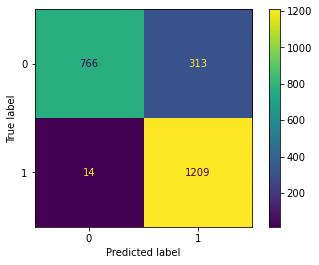

In [25]:
d_tree, results_df = grid_search(DecisionTreeClassifier, parameters, 'decision_tree', **splitted_dataset)

In [26]:
dot_data = export_graphviz(d_tree, out_file=None, feature_names=list(ts.columns), filled=True, rounded=True,
                           class_names=['genuine user', 'bot'])
graph = pydotplus.graph_from_dot_data(dot_data)
with open('./classification/decision_tree/dtree_graph.png', 'wb') as png:
    png.write(Image(graph.create_png()).data)

# Naive Bayes

In [27]:
labels = ['genuine user','bot']
parameters = {
    'alpha':[0.25,0.5,0.75,1, 2],
    'fit_prior': [True, False]
}

In [28]:
best_nb, results_df = grid_search(MultinomialNB, parameters, 'mn_naive_bayes', **splitted_dataset)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\al\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
50 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\al\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\al\anaconda3\lib\site-packages\sklearn\naive_bayes.py", line 690, in fit
    self._count(X, Y)
  File "C:\Users\al\anaconda3\lib\site-packages\sklearn\naive_bayes.py", line 863, in _count
    check_non_negative(X, "MultinomialNB (input X)")
  File "C:\Users\al\anaconda3\lib\site-packages\sklearn\ut

# Adaboost

In [29]:
parameters = {
    'base_estimator': [DecisionTreeClassifier(max_depth=4)],
    'n_estimators': [8,16,32,64,128],
    'learning_rate': [1e-2, 1e-1, 1, 1e1, 1e2],
    'algorithm': ['SAMME','SAMME.R'],
}

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best compo:
	params: {'algorithm': 'SAMME', 'base_estimator': DecisionTreeClassifier(max_depth=4), 'learning_rate': 0.01, 'n_estimators': 32}
	mean_train_recall: 0.992438187310705
	mean_train_precision: 0.7930500375936942
	mean_train_f1: 0.8816090144346609
	mean_val_recall: 0.9922340521085955
	mean_val_precision: 0.7928974863545848
	mean_val_f1: 0.8814020328444501

Accuracy 0.8579496090356212
Precision test set  0.8823296354690525
Recall test set  0.8579496090356212
F1 score test set  0.8542624182538155
Support test set  (array([0.98205128, 0.79434954]), array([0.70991659, 0.98855274]), array([0.82409898, 0.88087432]), array([1079, 1223], dtype=int64))
              precision    recall  f1-score   support

genuine_user       0.98      0.71      0.82      1079
         bot       0.79      0.99      0.88      1223

    accuracy                           0.86      2302
   macro avg       0.89      0.85      0.85      2302
weigh

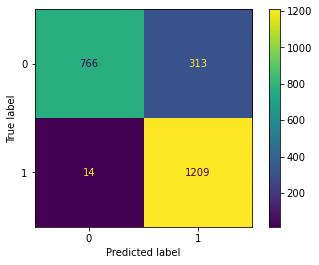

In [30]:
ab, results_df = grid_search(AdaBoostClassifier, parameters, 'adaboost', **splitted_dataset)

# Random Forest

In [61]:
parameters = {
    "n_estimators": range(50,500,100),
    "criterion": ["gini","entropy","log_loss"],
    "max_depth": [None] + list(range(5,100,10)),
    "min_samples_split": [2,4,8,16,32,64],
    "min_samples_leaf": [2,4,8,16,32,64,128],
    "max_features":["auto","sqrt","log2",None],
    "max_leaf_nodes":[None] + list(range(1,10,2)),
    "min_impurity_decrease": 0.1 * np.array(range(1,5))
}

'  \n"max_depth": [None] + list(range(5,100,10)),\n    #"min_samples_split": [2,4,8,16,32,64],\n    "min_samples_split": [2,16,64],\n    #"min_samples_leaf": [2,4,8,16,32,64,128],\n    "min_samples_leaf": [2,16,64,128],\n    "max_features":["auto","sqrt","log2",None],\n    "max_leaf_nodes":[None] + list(range(1,10,2)),\n    "min_impurity_decrease": 0.1 * np.array(range(1,5))\n'

In [63]:
rf, results_df = grid_search(RandomForestClassifier, parameters, 'random_forest', **splitted_dataset)

# SVM

In [19]:

parameters_linear = {
    'C': [1**(exp) for exp in [-2,-1,0,1,2,3,4]],
    'kernel': ['linear'],
    'shrinking': [True, False],
    'tol': [1e-8, 1e-4, 1e-2, 1e-1],
    'random_state': [42]
}

gamma_range = ['scale','auto'] + [1**(exp) for exp in [-3,-2,-1,0,1,2]]

parameters_poly = {
    **parameters_linear,
    'kernel': ['poly'],
    'degree': list(range(2,9)),
    'gamma': gamma_range,
}

parameters_rbf_sigmoid = {
    **parameters_linear,
    'kernel': ['rbf','sigmoid'],
    'gamma': gamma_range
}

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best compo:
	params: {'kernel': 'linear', 'random_state': 42}
	mean_train_recall: 1.0
	mean_train_precision: 0.5315011949658399
	mean_train_f1: 0.6940917775835678
	mean_val_recall: 1.0
	mean_val_precision: 0.5315011963591991
	mean_val_f1: 0.6940917479454318

Accuracy 0.5312771503040834
Precision test set  0.2822554104352276
Recall test set  0.5312771503040834
F1 score test set  0.3686535913883086
Support test set  (array([0.        , 0.53127715]), array([0., 1.]), array([0.        , 0.69390071]), array([1079, 1223], dtype=int64))
              precision    recall  f1-score   support

genuine_user       0.00      0.00      0.00      1079
         bot       0.53      1.00      0.69      1223

    accuracy                           0.53      2302
   macro avg       0.27      0.50      0.35      2302
weighted avg       0.28      0.53      0.37      2302



C:\Users\al\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\al\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\al\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\al\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:13

(SVC(kernel='linear', random_state=42),
    mean_fit_time  std_fit_time  mean_score_time  std_score_time param_kernel  \
 0       0.252749      0.034701         0.046657        0.005316       linear   
 1       3.567230      0.260925         0.598629        0.045717         poly   
 2       3.571965      0.444945         3.248197        3.139082          rbf   
 3       3.185667      0.095497         0.646143        0.059727      sigmoid   
 
   param_random_state                                     params  \
 0                 42   {'kernel': 'linear', 'random_state': 42}   
 1                 42     {'kernel': 'poly', 'random_state': 42}   
 2                 42      {'kernel': 'rbf', 'random_state': 42}   
 3                 42  {'kernel': 'sigmoid', 'random_state': 42}   
 
    split0_test_accuracy  split1_test_accuracy  split2_test_accuracy  ...  \
 0              0.531488              0.531776              0.531776  ...   
 1              0.531488              0.531776           

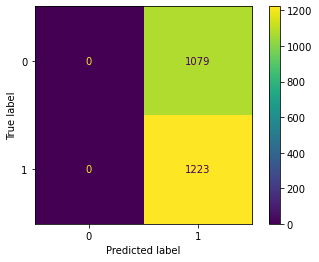

In [20]:
grid_search(SVC, [parameters_linear,parameters_poly,parameters_rbf_sigmoid], 'svm',**splitted_dataset, n_jobs=4)